In [ ]:
!pip install -q evaluate transformers datasets mlflow medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.1 MB/s eta 0:00:00
   ━━━

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score,
                             roc_auc_score,
                             confusion_matrix,
                             classification_report,
                             f1_score)

import evaluate
from datasets import Dataset, Image
from transformers import (TrainingArguments,
                          Trainer,
                          ViTImageProcessor,
                          ViTForImageClassification,
                          DefaultDataCollator)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomRotation,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomAdjustSharpness,
                                    Resize,
                                    ToTensor)

from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
import medmnist
from medmnist import INFO

# Specify dataset configuration
data_flag = 'pathmnist'  # Replace with desired dataset, e.g., 'breastmnist'
download = True

# Load dataset information and initialize dataset
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Load the dataset (e.g., training split)
dataset_instance = DataClass(split='train', download=download)

# Extract images and labels (samples are tuples, so use indexing)
data_dict = {
    "image": [sample[0] for sample in dataset_instance],  # sample[0] is the image
    "label": [sample[1] for sample in dataset_instance]   # sample[1] is the label
}

100%|██████████| 206M/206M [00:16<00:00, 12.6MB/s]


In [ ]:
test_dataset = DataClass(split='test', download=download)
print(test_dataset)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 7180
    Root location: /root/.medmnist
    Split: test
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the so

In [ ]:
len(data_dict)

2

In [ ]:
import pandas as pd

# Convert dictionary to pandas DataFrame
df = pd.DataFrame(data_dict)

# Show the first few rows of the DataFrame to preview
print(df.head())

                                               image label
0  <PIL.Image.Image image mode=RGB size=28x28 at ...   [0]
1  <PIL.Image.Image image mode=RGB size=28x28 at ...   [4]
2  <PIL.Image.Image image mode=RGB size=28x28 at ...   [7]
3  <PIL.Image.Image image mode=RGB size=28x28 at ...   [5]
4  <PIL.Image.Image image mode=RGB size=28x28 at ...   [5]


In [ ]:
words = [
    'adipose',
    'background',
    'debris',
    'lymphocytes',
    'mucus',
    'smooth muscle',
    'normal colon mucosa',
    'cancer-associated stroma',
    'colorectal adenocarcinoma epithelium'
]
image_dict = {}
# Define the list of file names
images = []
labels = []
for i in range(len(data_dict['image'])):
    images.append(data_dict['image'][i])
    labels.append(words[data_dict['label'][i][0]])

print(len(data_dict['image']), len(data_dict['label']))

dataset = Dataset.from_dict({"image": images, "label": labels})
print(dataset[0]["label"])
print(dataset[0]["image"])

89996 89996
adipose
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=28x28 at 0x7F50EF47B910>


In [ ]:
# '0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'
words = [
    'adipose',
    'background',
    'debris',
    'lymphocytes',
    'mucus',
    'smooth muscle',
    'normal colon mucosa',
    'cancer-associated stroma',
    'colorectal adenocarcinoma epithelium'
]

labels_list = list(set(dataset['label']))
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

print(id2label, '\n\n', label2id)

{0: 'lymphocytes', 1: 'mucus', 2: 'smooth muscle', 3: 'debris', 4: 'colorectal adenocarcinoma epithelium', 5: 'cancer-associated stroma', 6: 'adipose', 7: 'normal colon mucosa', 8: 'background'} 

 {'lymphocytes': 0, 'mucus': 1, 'smooth muscle': 2, 'debris': 3, 'colorectal adenocarcinoma epithelium': 4, 'cancer-associated stroma': 5, 'adipose': 6, 'normal colon mucosa': 7, 'background': 8}


In [ ]:
labels_list

['lymphocytes',
 'mucus',
 'smooth muscle',
 'debris',
 'colorectal adenocarcinoma epithelium',
 'cancer-associated stroma',
 'adipose',
 'normal colon mucosa',
 'background']

In [ ]:
print(label2id)

{'lymphocytes': 0, 'mucus': 1, 'smooth muscle': 2, 'debris': 3, 'colorectal adenocarcinoma epithelium': 4, 'cancer-associated stroma': 5, 'adipose': 6, 'normal colon mucosa': 7, 'background': 8}


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 89996
})

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)
train_data = dataset['train']
test_data = dataset['test']

In [ ]:
for i in range(len(train_data)):
  if train_data[i]['label'] == 0:
    print (i)
    break

In [ ]:
print(train_data[0]["label"])
print(train_data['label'][9])

colorectal adenocarcinoma epithelium
normal colon mucosa


In [ ]:
print(train_data[39]["image"])
print(train_data['image'][39])

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=28x28 at 0x7F50EEE48A90>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=28x28 at 0x7F50EEE4B5E0>


In [ ]:
model_str = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomRotation(15),
            RandomAdjustSharpness(2),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Size:  224


In [ ]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["label"]] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id
# number of trainable parameters
print(model.num_parameters(only_trainable=True)/1e6)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.805577


In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    # predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    # Calculate accuracy using the loaded accuracy metric
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']


    return {
        "accuracy": acc_score
    }

In [ ]:
metric_name = "accuracy"
model_name = "butterfly_moth_species_detection"
num_train_epochs=20
args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=4,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1, # save fewer checkpoints to limit used space
    report_to="mlflow",  # log to mlflow
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
trainer.evaluate()

{'eval_loss': 2.198441743850708,
 'eval_model_preparation_time': 0.0051,
 'eval_accuracy': 0.08494444444444445,
 'eval_runtime': 220.1408,
 'eval_samples_per_second': 81.766,
 'eval_steps_per_second': 20.441}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.231100,0.188055,0.005100,0.970778
2,0.108000,0.095160,0.005100,0.977778


KeyboardInterrupt: 

In [ ]:
trainer.evaluate()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.231100,0.188055,0.005100,0.970778
2,0.108000,0.101199,0.005100,0.976944


{'eval_loss': 0.10119897872209549,
 'eval_model_preparation_time': 0.0051,
 'eval_accuracy': 0.9769444444444444}

In [ ]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.231100,0.188055,0.005100,0.970778
2,0.108000,0.101199,0.005100,0.976944


{'test_loss': 0.10119897872209549, 'test_model_preparation_time': 0.0051, 'test_accuracy': 0.9769444444444444, 'test_runtime': 242.1097, 'test_samples_per_second': 74.346, 'test_steps_per_second': 18.587}


In [ ]:
%matplotlib inline

Accuracy: 0.9769
F1 Score: 0.9771


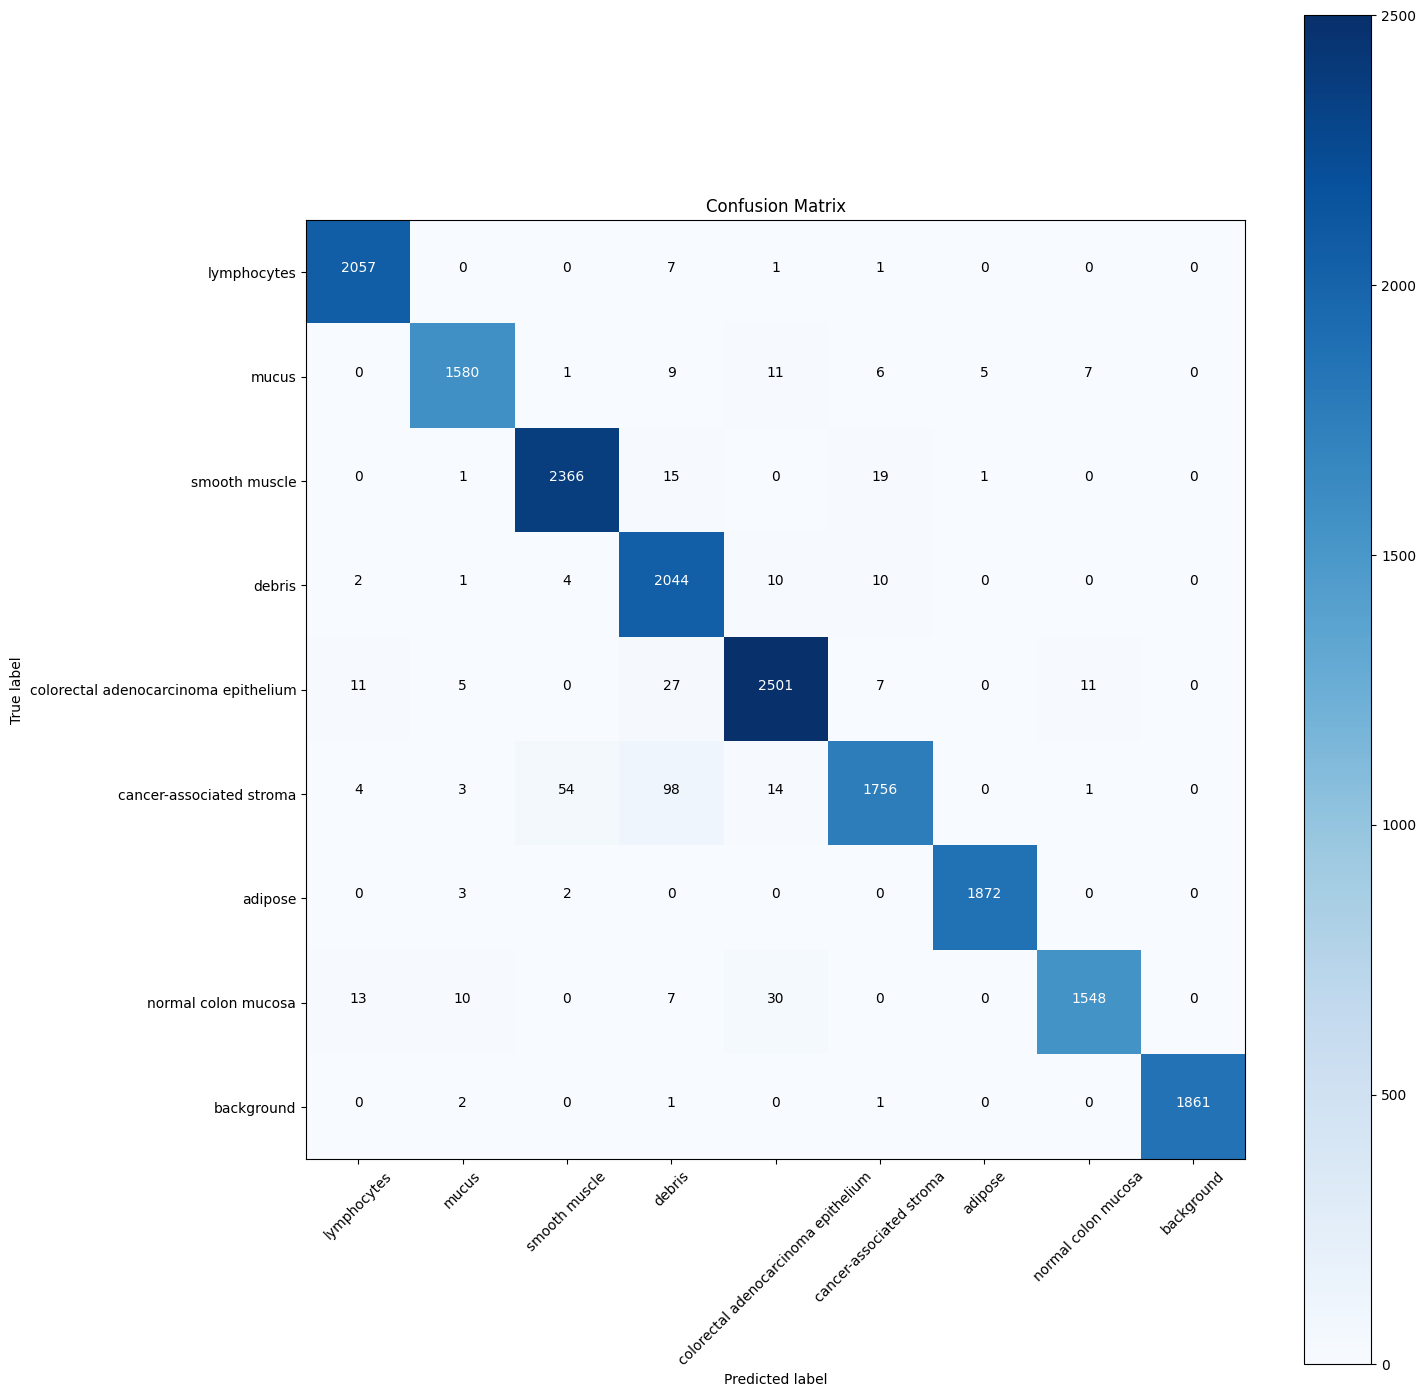

In [ ]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# plotting confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plot_confusion_matrix(cm, labels_list)

In [ ]:
trainer.save_model()

In [ ]:
from transformers import pipeline

pipe = pipeline('image-classification',model=model_name,device=0)

In [ ]:
image = dataset["test"][0]["image"]

image

In [ ]:
pipe(image)

[{'label': 'normal colon mucosa', 'score': 0.9909251928329468},
 {'label': 'colorectal adenocarcinoma epithelium',
  'score': 0.4930970370769501},
 {'label': 'mucus', 'score': 0.43264877796173096},
 {'label': 'lymphocytes', 'score': 0.38520529866218567},
 {'label': 'background', 'score': 0.3193590044975281}]

In [ ]:
dataset["test"][0]["label"]

'normal colon mucosa'